In [ ]:
!pip uninstall scikit-learn pandas seaborn ibm-watson-machine-learning imbalanced-learn -y
!pip install scikit-learn==1.4.2 pandas==2.1.4 numpy==1.26.4 matplotlib==3.8.4 seaborn==0.13.2 imbalanced-learn==0.12.3 ibm-watson-machine-learning==1.0.360


Found existing installation: scikit-learn 1.3.0
Uninstalling scikit-learn-1.3.0:
  Successfully uninstalled scikit-learn-1.3.0
Found existing installation: pandas 2.1.4
Uninstalling pandas-2.1.4:
  Successfully uninstalled pandas-2.1.4
Found existing installation: seaborn 0.12.2
Uninstalling seaborn-0.12.2:
  Successfully uninstalled seaborn-0.12.2
Found existing installation: ibm_watson_machine_learning 1.0.368
Uninstalling ibm_watson_machine_learning-1.0.368:
  Successfully uninstalled ibm_watson_machine_learning-1.0.368
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
  Using cached ibm_watson_machine_learning-1.0.360-py3-none-any.whl.metadata (4.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from ibm_watson_machine_learning import APIClient
import warnings
import sys
import os
warnings.filterwarnings('ignore')

In [ ]:
# Step 1: Verify Python version and environment
print(f"Python Version: {sys.version}")
if '3.11' not in sys.version:
    print("Error: This code requires Python 3.11 (runtime-24.1). Please switch environments.")
    exit(1)

Python Version: 3.11.13 (main, Jun  5 2025, 13:12:00) [GCC 11.2.0]


In [ ]:
# Step 2: Verify package versions
try:
    import sklearn
    print(f"scikit-learn version: {sklearn.__version__}")  # Should be 1.4.2
    import pandas
    print(f"pandas version: {pandas.__version__}")  # Should be 2.1.4
    import seaborn
    print(f"seaborn version: {seaborn.__version__}")  # Should be 0.13.2
    import imblearn
    print(f"imbalanced-learn version: {imblearn.__version__}")  # Should be 0.12.3
except ImportError as e:
    print(f"Error importing dependencies: {e}. Reinstall packages with the updated command above.")
    exit(1)

scikit-learn version: 1.4.2
pandas version: 2.1.4
seaborn version: 0.13.2
imbalanced-learn version: 0.12.3


In [ ]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='vruZaLq0PEALfbCrE1l94ortPzn_jCL_1RCw4Y1dzHao',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/identity/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.direct.us-south.cloud-object-storage.appdomain.cloud')

bucket = 'problem39-donotdelete-pr-bqtlnwsijhnd2y'
object_key = 'predictive_maintenance.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head(10)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,No Failure
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,No Failure
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,No Failure
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,No Failure
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,No Failure


In [ ]:
# Step 4: Data Preprocessing
# Drop irrelevant columns
data = data.drop(['UDI', 'Product ID'], axis=1)
print("Dropped irrelevant columns.")

# Encode categorical variables
type_mapping = {'L': 0, 'M': 1, 'H': 2}
data['Type'] = data['Type'].map(type_mapping)
failure_mapping = {
    'No Failure': 0,
    'Overstrain Failure': 1,
    'Power Failure': 2,
    'Random Failure': 3,
    'Tool Wear Failure': 4,
    'Heat Dissipation Failure': 5
}
data['Failure Type'] = data['Failure Type'].map(failure_mapping).fillna(0).astype('int32')  # Ensure integer type

# Check for floating-point issues
print("Failure Type dtype:", data['Failure Type'].dtype)
print("Unique Failure Type values:", data['Failure Type'].unique())


# Handle missing values
data = data.dropna()
print(f"Removed {data.shape[0]} rows after handling missing values.")

# Define features and target
X = data[['Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
y = data['Failure Type']
print("Features and target defined.")

# Normalize numerical features
try:
    scaler = StandardScaler()
    X[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] = scaler.fit_transform(
        X[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
    )
    print("Numerical features normalized.")
except Exception as e:
    print(f"Error normalizing features: {e}")
    exit(1)

# Split data into training and testing sets
try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("Data split into training and testing sets.")
except Exception as e:
    print(f"Error splitting data: {e}")
    exit(1)

Dropped irrelevant columns.
Failure Type dtype: int32
Unique Failure Type values: [0 2 4 1 5]
Removed 10000 rows after handling missing values.
Features and target defined.
Numerical features normalized.
Data split into training and testing sets.


In [ ]:
print(data['Type'])


0       1
1       0
2       0
3       0
4       0
       ..
9995    1
9996    2
9997    1
9998    2
9999    1
Name: Type, Length: 10000, dtype: int64


In [ ]:
print(data['Failure Type'][3236])

5


In [ ]:
# Step 5: Handle class imbalance with SMOTE
try:
    smote = SMOTE(random_state=42)
    X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
    print("Class imbalance handled with SMOTE.")
except Exception as e:
    print(f"Error applying SMOTE: {e}")
    exit(1)

Class imbalance handled with SMOTE.


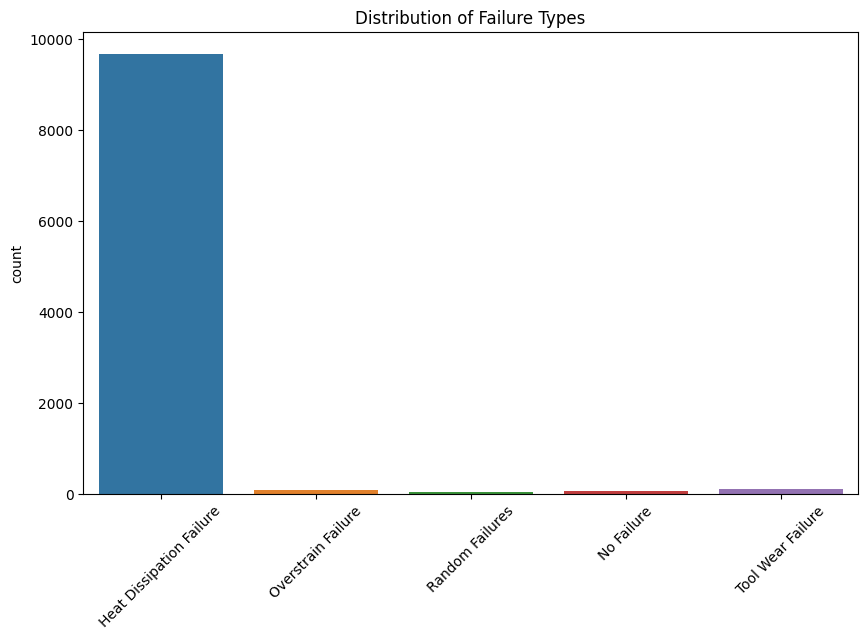

Failure type distribution plot saved.


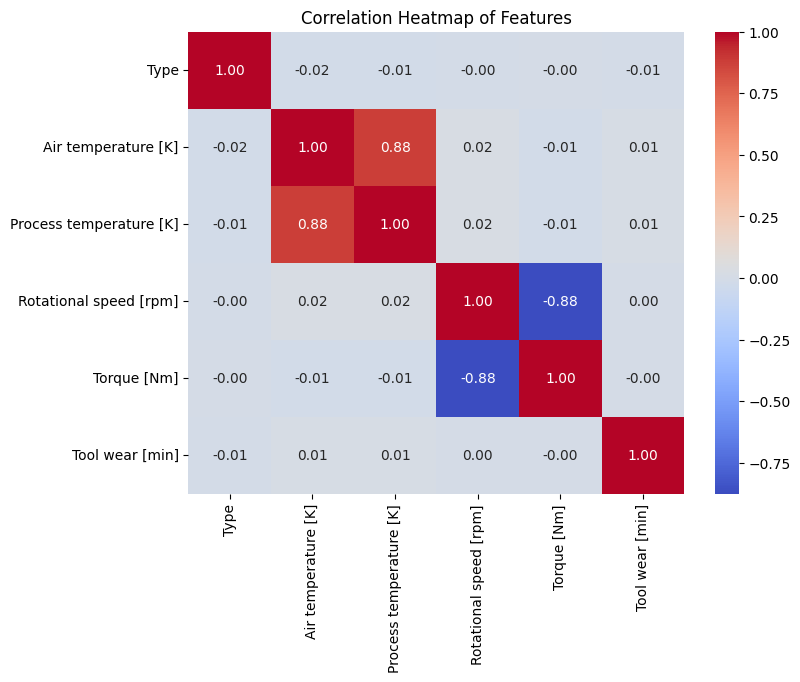

Correlation heatmap saved.


In [ ]:
# Step 6: Exploratory Data Analysis (EDA)
# Plot distribution of Failure Types
try:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=le_failure.inverse_transform(y), hue=le_failure.inverse_transform(y), legend=False)
    plt.title('Distribution of Failure Types')
    plt.xticks(rotation=45)
    plt.show()
    plt.savefig('failure_type_distribution.png')
    plt.close()
    print("Failure type distribution plot saved.")
except Exception as e:
    print(f"Error plotting failure type distribution: {e}")

# Correlation heatmap
try:
    plt.figure(figsize=(8, 6))
    sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Features')
    plt.show()
    plt.savefig('correlation_heatmap.png')
    plt.close()
    print("Correlation heatmap saved.")
except Exception as e:
    print(f"Error plotting correlation heatmap: {e}")


In [ ]:
# Step 7: Model Training
# Use DecisionTreeClassifier for simplicity
model = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
try:
    model.fit(X_train_bal, y_train_bal)
    print("Model trained successfully!")
except Exception as e:
    print(f"Error training model: {e}")
    exit(1)

Model trained successfully!


In [ ]:
# Step 8: Model Evaluation
try:
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le_failure.classes_))
except Exception as e:
    print(f"Error evaluating model: {e}")
    exit(1)


Classification Report:
Error evaluating model: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter


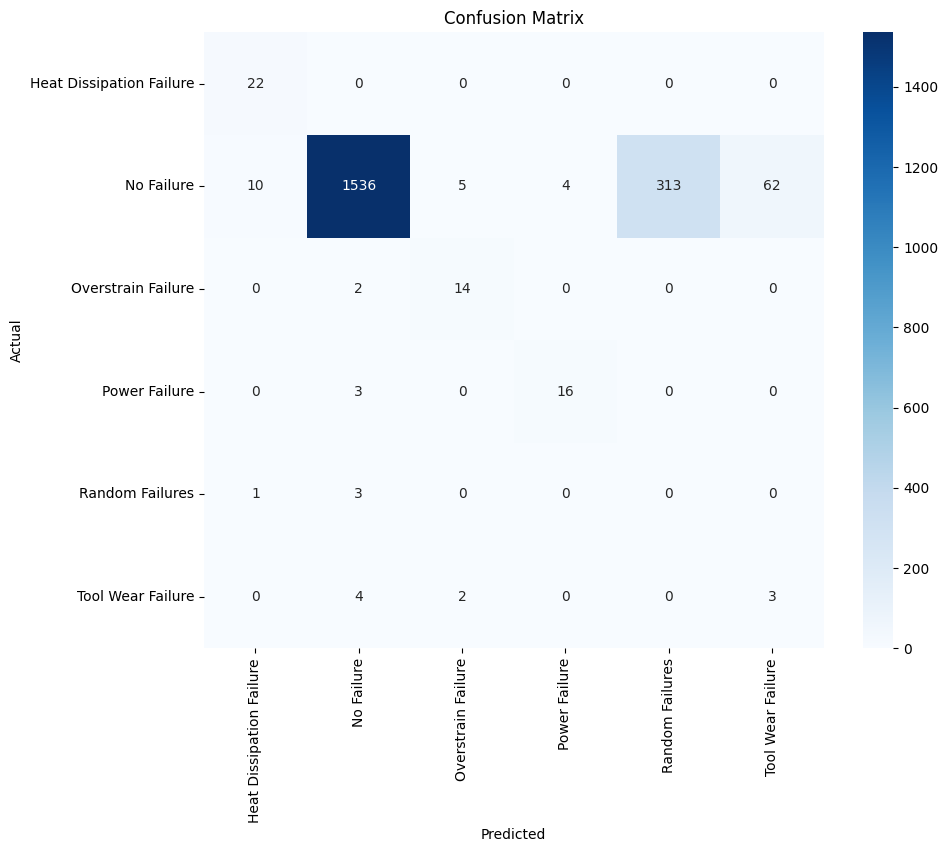

Confusion matrix saved.


In [ ]:
# Confusion Matrix
try:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_failure.classes_, yticklabels=le_failure.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    plt.savefig('confusion_matrix.png')
    plt.close()
    print("Confusion matrix saved.")
except Exception as e:
    print(f"Error plotting confusion matrix: {e}")

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.93


In [ ]:
from ibm_watson_machine_learning import APIClient

# WML credentials
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "0PwD4djl7kN_KbqoTAroPHbmvp0B_0SkHyKsXC9wmFSa",
}

try:
    client = APIClient(wml_credentials)
    client.set.default_project('08d6aa5d-90b9-4da6-ac61-997eb27d0c9e')
    print("Connected to Watson Machine Learning.")

    # Define model metadata
    model_props = {
        client.repository.ModelMetaNames.NAME: "PredictiveMaintenanceModel",
        client.repository.ModelMetaNames.TYPE: "scikit-learn_1.3",
        client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: client.software_specifications.get_uid_by_name("runtime-24.1-py3.11")
    }

    # Store the model
    model_details = client.repository.store_model(model=model, meta_props=model_props, training_data=X_train_bal, training_target=y_train_bal)
    model_id = client.repository.get_model_id(model_details)
    print(f"Model saved with ID: {model_id}")
except Exception as e:
    print(f"Error saving model to Watson Machine Learning: {e}")
    print("Tip: Verify your API key, project ID, and ensure Watson Machine Learning is enabled.")


Connected to Watson Machine Learning.
Model saved with ID: df9879f4-294a-4789-b82d-0a5455cd7aa6


In [ ]:
# Step 10: Example Prediction Function
def predict_failure(data_point):
    try:
        df = pd.DataFrame([data_point])
        df['Type'] = le_type.transform(df['Type'])
        df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']] = scaler.transform(
            df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]
        )
        prediction = model.predict(df)
        return le_failure.inverse_transform(prediction)[0]
    except Exception as e:
        return f"Error in prediction: {e}"

In [ ]:
# Example usage
sample_data = {
    'Type': 'L',
    'Air temperature [K]': 298.9,
    'Process temperature [K]': 309.1,
    'Rotational speed [rpm]': 2861,
    'Torque [Nm]': 4.6,
    'Tool wear [min]': 143
}
print(f"Predicted Failure Type: {predict_failure(sample_data)}")

Predicted Failure Type: Overstrain Failure
